# Notebook 2: Factor Analysis

---

## **Table of Contents** ##

1. [Introduction](#1)
2. [Loading and Setup](#2)
3. [PCA](#3)
    - [Scaling and PCA](#3a)
    - [Factor loadings and interpretations](#3b)
    - [Remove 1_month and repeat PCA](#3c)
4. [Summary, Insights, and Practical Application](#4)


---

## 1. Introduction <a class="anchor" id="1"></a>

This notebook performs principal component analysis (PCA) on daily yield changes for U.S. Treasury maturities (Jan 2019 - Oct 2025) to evaluate whether the classic Level–Slope–Curvature (LSC) framework is able to describe curve dynamics over the sample. PCA is used to:

- Extract the dominant orthogonal factors (scores and loadings) driving yield-change variability.
- Quantify variance explained by the leading components and test whether the first three components correspond to Level, Slope, and Curvature.
- Examine temporal stability of loadings and factor importance across regimes (pre/post major events), and identify periods where LSC fails or shifts.
- Provide factor time series to feed into dynamic models (VAR / Dynamic Nelson–Siegel) and rolling-window backtests in later notebooks.

---

## 2. Loading and Setup <a class="anchor" id="2"></a>

In [187]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [188]:
# Import the clean dataset
yield_df = pd.read_csv("../data/yield_cleaned.csv", index_col=0)

In [189]:
# Convert index to datetime
yield_df.index = pd.to_datetime(yield_df.index)

In [190]:
# Check top five rows 
yield_df.head()

,1_month,3_month,6_month,1_year,2_year,3_year,5_year,7_year,10_year,20_year,30_year
2019-01-02,2.40,2.42,2.51,2.60,2.50,2.47,2.49,2.56,2.66,2.83,2.97
2019-01-03,2.42,2.41,2.47,2.50,2.39,2.35,2.37,2.44,2.56,2.75,2.92
2019-01-04,2.40,2.42,2.51,2.57,2.50,2.47,2.49,2.56,2.67,2.83,2.98
2019-01-07,2.42,2.45,2.54,2.58,2.53,2.51,2.53,2.60,2.70,2.86,2.99
2019-01-08,2.40,2.46,2.54,2.60,2.58,2.57,2.58,2.63,2.73,2.88,3.00


---

## 3. PCA <a class="anchor" id="2"></a>

### 3.1 Scaling and PCA <a class="anchor" id="3a"></a>

In [191]:
# Calculate the yield changes 
yield_changes = yield_df.diff().dropna()

yield_changes.head(3)

,1_month,3_month,6_month,1_year,2_year,3_year,5_year,7_year,10_year,20_year,30_year
2019-01-03,0.02,-0.01,-0.04,-0.10,-0.11,-0.12,-0.12,-0.12,-0.10,-0.08,-0.05
2019-01-04,-0.02,0.01,0.04,0.07,0.11,0.12,0.12,0.12,0.11,0.08,0.06
2019-01-07,0.02,0.03,0.03,0.01,0.03,0.04,0.04,0.04,0.03,0.03,0.01


Apply Standard Scaler

In [192]:
# Apply standard scaler
scaler = StandardScaler()

# Fit transform the dataset
yield_changes_scaled = scaler.fit_transform(yield_changes)

Apply PCA

In [193]:
# Apply PCA on scaled yield changes
pca = PCA(n_components=None)

# Fit the PCA
pca.fit(yield_changes_scaled)

PCA()

Visualize explained variance ratio

In [194]:
# Get explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Calculate the cumulative explained variance ratio
cumulative_variance = np.cumsum(explained_variance_ratio)

In [195]:
# Show the first three explain variance ratio
for i in range(3):
    print(f"PCA number:{i + 1}; explained ratio:{explained_variance_ratio[i]:.1%}; total explained ratio:{cumulative_variance[i]:.1%}")

PCA number:1; explained ratio:65.7%; total explained ratio:65.7%
PCA number:2; explained ratio:14.2%; total explained ratio:79.9%
PCA number:3; explained ratio:9.0%; total explained ratio:88.9%


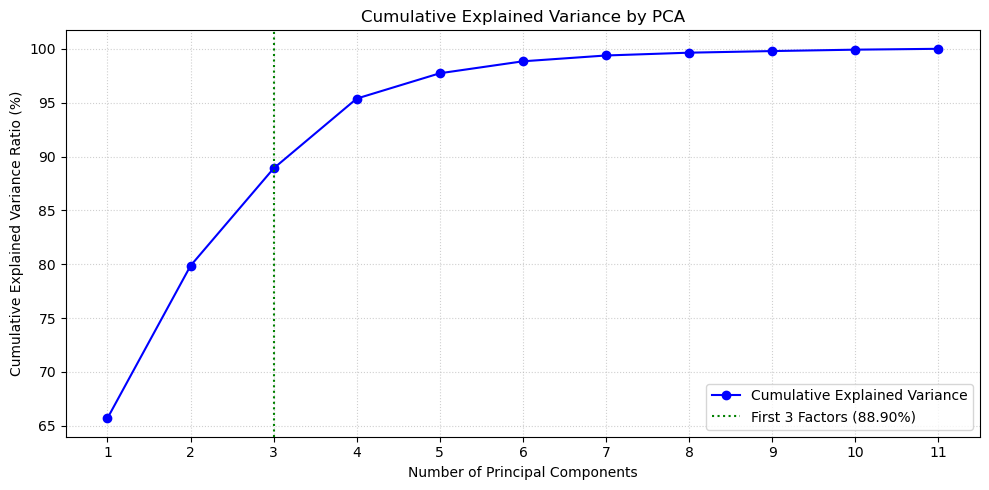

In [196]:
# Visualize total explained ratio
fig1 = plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, len(cumulative_variance) + 1), 
         (cumulative_variance * 100).round(2), 
         marker='o', 
         linestyle='-', 
         color='blue', 
         label='Cumulative Explained Variance')
plt.axvline(3, color='green', linestyle=':', label=f'First 3 Factors ({cumulative_variance[2]:.2%})')
plt.title('Cumulative Explained Variance by PCA')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio (%)')
plt.xticks(np.arange(1, len(cumulative_variance) + 1))
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show() 


The first three principal components explained about 88% of the yield changes variance, which is farily sufficient to support the use of LSC framework. 

---

### 3.2 Factor loadings and interpretations <a class="anchor" id="3b"></a>

Plot factor loadings

Loadings are the eigenvectors of the principal componenets, showing the weights for each maturity. Based on Nelson-Siegel model, the yield curve change is decomposed into Level, Slope, and Curvature, so we will focus on the factor loadings for the first three PCs.

In [197]:
# Get the loadings for the first three PCs
loadings = pca.components_[:3, :].T

In [198]:
# Create a DataFrame of loadings for easier visualization
loadings_df = pd.DataFrame(loadings, index=yield_changes.columns, columns=['PC 1', 'PC 2', 'PC 3'])

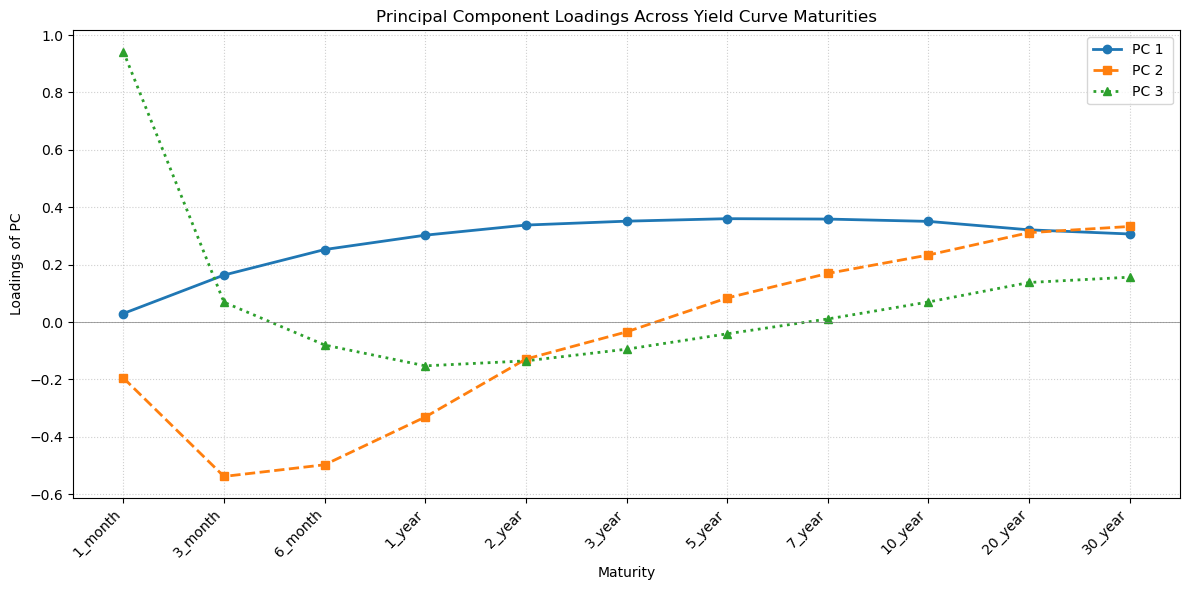

In [199]:
# Visualize the loadings 
fig2 = plt.figure(figsize=(12, 6))

# Define ordinal x-axis values and simplified labels
x_ordinal = np.arange(len(loadings_df.index))
maturity_labels = loadings_df.index

# Plot the three components
plt.plot(x_ordinal, loadings_df['PC 1'], marker='o', linestyle='-', label='PC 1 ', linewidth=2)
plt.plot(x_ordinal, loadings_df['PC 2'], marker='s', linestyle='--', label='PC 2 ', linewidth=2)
plt.plot(x_ordinal, loadings_df['PC 3'], marker='^', linestyle=':', label='PC 3 ', linewidth=2)


plt.title('Principal Component Loadings Across Yield Curve Maturities')
plt.xlabel('Maturity')
plt.ylabel('Loadings of PC')
plt.xticks(x_ordinal, maturity_labels, rotation=45, ha='right')
plt.axhline(0, color='grey', linestyle='-', linewidth=0.5)
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show() # Display the plot


Interpretations:

PC 1: The Level Factor (Parallel Shift)
<br>Observation: The loadings are uniformly positive and relatively high, ranging from 0.03 (1 month ) to 0.36 (5 year). The values stay high across the entire spectrum.
<br>Interpretation: This factor affects all maturities roughly equally. An increase in this PC's score causes the entire yield curve to shift up in a parallel fashion.

PC 2: The Slope Factor (Tilt or slope change)
<br>Observation: The loadings start negative at the short end (e.g., -0.2 at 1 month , -0.54 at 3 month) and transition to positive at the long end (e.g., 0.234 at 10Y, 0.333 at 30Y). It crosses zero around the 5-7 year mark.
<br>Interpretation: An increase in this PC's score applies a negative shock to the short end and a positive shock to the long end. This increases the $Y_{10Y} - Y_{2Y}$ spread, causing the curve to steepen.

PC 3 (Short-Rate/Policy Factor): 
<br>Observation: This PC is overwhelmingly dominated by the 1-month yield (loading of +0.94). It is a highly localized factor that captures movements in the very shortest end of the curve, likely due to central bank policy rate volatility. 
<br>Interpretation: While the Level, Slope, and Curvature (LSC) framework assigns the Curvature role to the third factor, our empirical PC 3 functions instead as a Short-Rate/Policy Factor. The outsized volatility of the policy-sensitive 1-month rate has effectively commandeered the component, obscuring the subtle, true curvature shape that should capture the mid-curve hump.

Takeaways:
<br>In EDA we observed substantial curvature changes across regimes from 2019–2025. To ensure one of the leading principal components captures curvature rather than short-term policy noise, I will exclude the 1‑month yield change from the PCA. Short-term (1 month) moves are heavily influenced by the Fed’s target rate and can be analyzed separately, and because the 1‑month tenor has very low duration its fluctuations have little impact on bond prices. I will therefore drop the 1‑month series and repeat the analysis.

---

### 3.3 Remove 1 month yield and repeat <a class="anchor" id="3c"></a>

In [200]:
# Remove 1 month yield changes 
new_yield_changes = yield_changes.drop(columns=['1_month'])

# Check the head
new_yield_changes.head(3)

,3_month,6_month,1_year,2_year,3_year,5_year,7_year,10_year,20_year,30_year
2019-01-03,-0.01,-0.04,-0.10,-0.11,-0.12,-0.12,-0.12,-0.10,-0.08,-0.05
2019-01-04,0.01,0.04,0.07,0.11,0.12,0.12,0.12,0.11,0.08,0.06
2019-01-07,0.03,0.03,0.01,0.03,0.04,0.04,0.04,0.03,0.03,0.01


In [201]:
# Apply standard scaler
new_scaler = StandardScaler()

# Fit transform the dataset
new_yield_changes_scaled = scaler.fit_transform(new_yield_changes)

In [202]:
# Apply PCA on scaled yield changes
new_pca = PCA(n_components=None)

# Fit the PCA
new_pca.fit(new_yield_changes_scaled)

PCA()

In [203]:
# Get explained variance ratio
new_explained_variance_ratio = new_pca.explained_variance_ratio_

# Calculate the cumulative explained variance ratio
new_cumulative_variance = np.cumsum(new_explained_variance_ratio)

# Show the first three explain variance ratio
for i in range(3):
    print(f"PCA number:{i + 1}; explained ratio:{new_explained_variance_ratio[i]:.1%}; total explained ratio:{new_cumulative_variance[i]:.1%}")

PCA number:1; explained ratio:72.2%; total explained ratio:72.2%
PCA number:2; explained ratio:15.4%; total explained ratio:87.6%
PCA number:3; explained ratio:7.3%; total explained ratio:94.9%


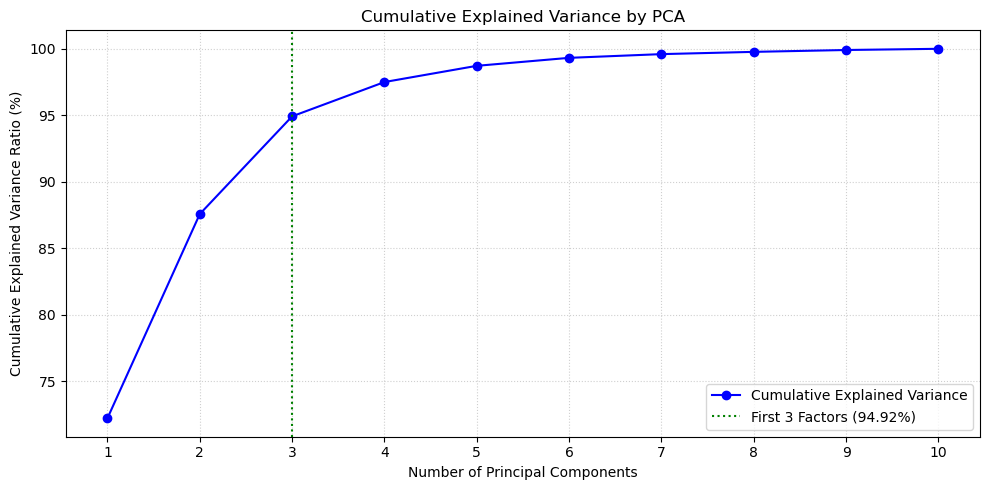

In [204]:
# Visualize total explained ratio
fig3 = plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, len(new_cumulative_variance) + 1), 
         (new_cumulative_variance * 100).round(2), 
         marker='o', 
         linestyle='-', 
         color='blue', 
         label='Cumulative Explained Variance')
plt.axvline(3, color='green', linestyle=':', label=f'First 3 Factors ({new_cumulative_variance[2]:.2%})')
plt.title('Cumulative Explained Variance by PCA')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio (%)')
plt.xticks(np.arange(1, len(new_cumulative_variance) + 1))
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show() 


- Insights:
After removing 1_month yield changes in the dataset, our updated PCA cumulative explained ratio of the first three PCs increased significantly, increasing from 88.9% to 94.9%.

In [205]:
# Get the loadings from the first three PCs
new_loadings = new_pca.components_[:3, :].T

# Create a DataFrame for easier visualization
new_loadings_df = pd.DataFrame(new_loadings, index=new_yield_changes.columns, columns=['PC 1', 'PC 2', 'PC 3'])

In [207]:
new_loadings_df

,PC 1,PC 2,PC 3
3_month,0.163297,-0.537510,0.630795
6_month,0.252456,-0.507543,0.124030
1_year,0.302744,-0.344285,-0.294652
2_year,0.338134,-0.140233,-0.367791
3_year,0.351735,-0.042078,-0.296636
5_year,0.360476,0.079920,-0.159693
7_year,0.359144,0.169510,-0.035805
10_year,0.351034,0.238503,0.109159
20_year,0.321585,0.321134,0.315127
30_year,0.307124,0.344069,0.372327


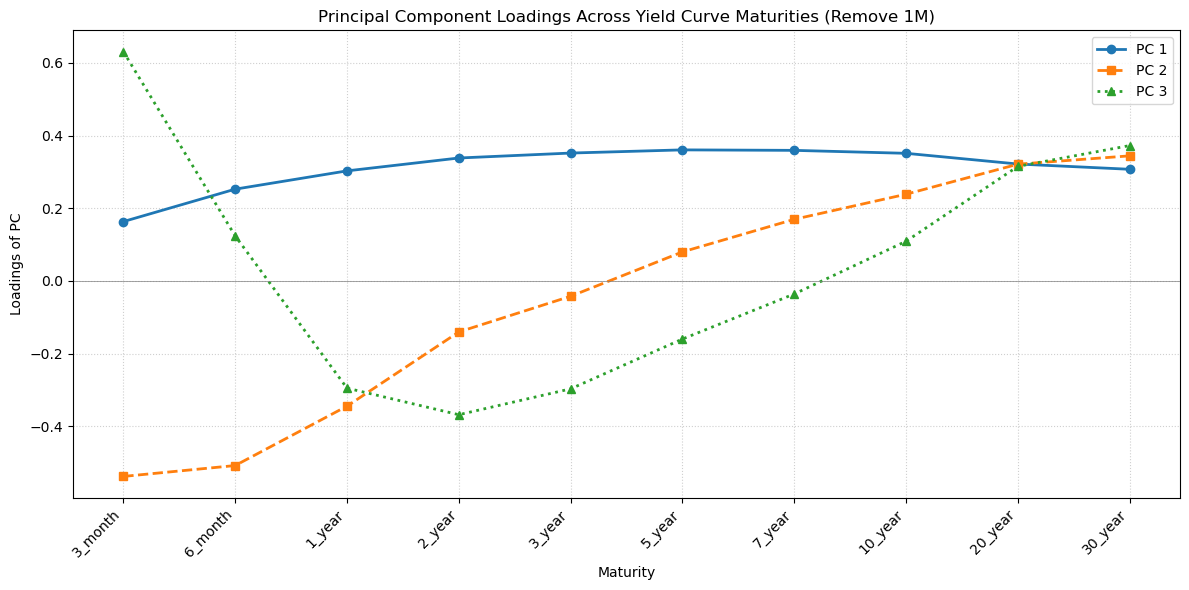

In [206]:
# Visualize the loadings 
fig4 = plt.figure(figsize=(12, 6))

# Define ordinal x-axis values and simplified labels
new_x_ordinal = np.arange(len(new_loadings_df.index))
maturity_labels = new_loadings_df.index

# Plot the three components
plt.plot(new_x_ordinal, new_loadings_df['PC 1'], marker='o', linestyle='-', label='PC 1', linewidth=2)
plt.plot(new_x_ordinal, new_loadings_df['PC 2'], marker='s', linestyle='--', label='PC 2', linewidth=2)
plt.plot(new_x_ordinal, new_loadings_df['PC 3'], marker='^', linestyle=':', label='PC 3', linewidth=2)


plt.title('Principal Component Loadings Across Yield Curve Maturities (Remove 1M)')
plt.xlabel('Maturity')
plt.ylabel('Loadings of PC')
plt.xticks(new_x_ordinal, maturity_labels, rotation=45, ha='right')
plt.axhline(0, color='grey', linestyle='-', linewidth=0.5)
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show() 


Insights:
<br>After removing the 1-month yield from the analysis, the first three principal components now clearly reflect the Level, Slope, and Curvature changes in the yield curve, validating the theoretical framework.

PC1 (Level): The loadings are uniformly positive across all term yields, reflecting a parallel shift or level change of the entire yield curve upon changes in this factor.

PC2 (Slope): Loadings are negative for short terms (3M to 3Y) and positive for longer terms. A positive change in this PC steepens the curve by widening the spread, capturing the curve's primary tilt.

PC3 (Curvature): This factor now clearly reflects the classic Curvature shape. It is positive at the endpoints (+0.63 at 3M, +0.37 at 30Y) and strongly negative in the middle (e.g., -0.37 at 2Y), representing the non-linear butterfly or bowing movement. A positive change in this PC increase the yield of both short and long terms while decreasing the yield in the intermediate terms, making the curve more convex.

---

## 4. Summary, Insights, and Practical Application <a class="anchor" id="4"></a>

## I. Summary: The Three‑Factor Model

This report documents a robust, low‑dimensional factor model from PCA on daily yield changes (2019–2025).

| Component | Economic Interpretation | Variance Explained | Significance |
|---|---:|:---:|---|
| PC1 | Level (parallel shift) | ≈ majority | Drives overall interest‑rate direction |
| PC2 | Slope (short vs. long) | ≈ significant | Drives curve flattening / steepening |
| PC3 | Curvature (short/long vs. medium) | ≈ residual | Drives the “hump” / concavity of the curve |

**Concluding insight:** PCA strongly supports a three‑factor dynamic representation. Moving to a Dynamic Nelson–Siegel (DNS) approach (or a PCA → VAR → NS mapping) is appropriate — it combines PCA’s parsimony with LSC’s economic interpretability, which is directly useful for trading and risk management.

---

## II. Practical Application for Financial Professionals

The LSC factors reduce high‑dimensional yield data to three orthogonal, actionable risk drivers. Below are concrete ways these factors can be applied by traders, portfolio managers, and risk analysts.

### For Fixed‑Income Traders & Portfolio Managers

- **Factor‑based hedging (risk neutralization)**  
  - Level hedge (PC1): replicate traditional duration neutralization using the Level exposure.  
  - Slope hedge (PC2): construct positions that are duration‑neutral but sensitive to slope moves (isolate flattening/steepening risk).  
  - Curvature hedge (PC3): hedge relative mispricing of the curve belly versus the wings (useful for bullet vs. barbell positioning and derivatives like swaptions).

- **Factor‑driven forecasting and execution**  
  - Fit time series models on factor time series for 1–6 month forecasts; translate factor forecasts back into tenor moves to inform trade timing and sizing.  
  - Combine factor forecasts with transaction‑cost models to decide whether to rebalance or tolerate residual exposure.
  - Use PCA loadings to find the minimal instrument set that approximates a target factor exposure.

### For Risk Analysts 

- **Risk attribution & simplified VaR**  
  - Decompose portfolio variance into independent (orthogonal) factor contributions:  
    $$\text{Total Risk}^2 \approx \text{Risk}_{\text{PC1}}^2 + \text{Risk}_{\text{PC2}}^2 + \text{Risk}_{\text{PC3}}^2$$
  - Report factor‑level contributions to VaR (e.g., 85% Level, 10% Slope, 5% Curvature) for clearer mitigation priorities.
  - Recompute PCA loadings periodically and monitor loading stability; document changes as part of model governance.

- **Stress testing & scenario design**  
  - Shock single factors (e.g., PC2 = +3σ) and map to tenor shocks to measure isolated P&L impact — more realistic than arbitrary parallel shifts.  
  - Generate multi‑factor scenarios (combinations of Level, Slope, Curvature moves) that reflect plausible market regimes.

---

## III. Implementation & Operational Tips

- Recompute PCA loadings on a regular cadence (monthly or quarterly) and monitor for structural breaks.  
- Reconstruct PCA when outliers or regime shifts distort the factors.   
- Backtest factor‑based hedging strategies including transaction costs and lot‑size constraints to ensure economic viability.

---

## IV. Short Recommendation

Adopt the three‑factor LSC framework as the primary monitoring and decomposition layer: use it for real‑time alerts, portfolio decomposition, targeted hedging, forecasting, and stress testing. Pair factor forecasts with domain insights and transaction‑cost checks so signals translate into actionable, cost‑effective trades and clearer risk management decisions.

In [186]:
# Data export
new_yield_changes.to_csv("../data/yield_changes_from_3_month.csv")

In [208]:
# Save the loadings to a CSV file
new_loadings_df.to_csv('../data/pca_loadings.csv')